# Introductory Example

This demonstrates an example using scalecast `0.17.0`. Several features explored are not available in earlier versions, so if anything is not working, try upgrading:

`pip install --upgrade scalecast`

If things are still not working, you spot a typo, or you have some other suggestion to improve functionality or document readability, open an [issue](https://github.com/mikekeith52/scalecast/issues/new) or email mikekeith52@gmail.com.

Link to dataset used in this example: https://www.kaggle.com/datasets/neuromusic/avocado-prices.  

Latest [official documentation](https://scalecast.readthedocs.io/en/latest/index.html).  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
# read in data
data = pd.read_csv('avocado.csv',parse_dates = ['Date'])
data = data.sort_values(['region','type','Date'])

[Univariate Forecasting](#Univariate-Forecasting)  
[Multivariate Forecasting](#Multivariate-Forecasting)  
[Transformations](#Transformations)  
[Pipelines](#Pipelines)  
[Fully Automated Pipelines](#Fully-Automated-Pipelines)  
[Scaled Automated Forecasting](#Scaled-Automated-Forecasting)  
[Exporting Results](#Exporting-Results)  

## Univariate Forecasting

### Load the `Forecaster` Object
- This is an object that can store data, run forecasts, store results, and plot. It's a UI, procedure, and set of models all-in-one.
- Forecasts in scalecast are run with a dynamic recursive approach by default, as opposed to a direct or other approach.
- [Forecaster Object Documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html).

In [4]:
from scalecast.Forecaster import Forecaster

In [5]:
volume = data.groupby('Date')['Total Volume'].sum()

In [6]:
f = Forecaster(
    y = volume,
    current_dates = volume.index,
    future_dates = 13,
)

f

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=[]
    Differenced=0
    TestLength=0
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

### Exploratory Data Analysis

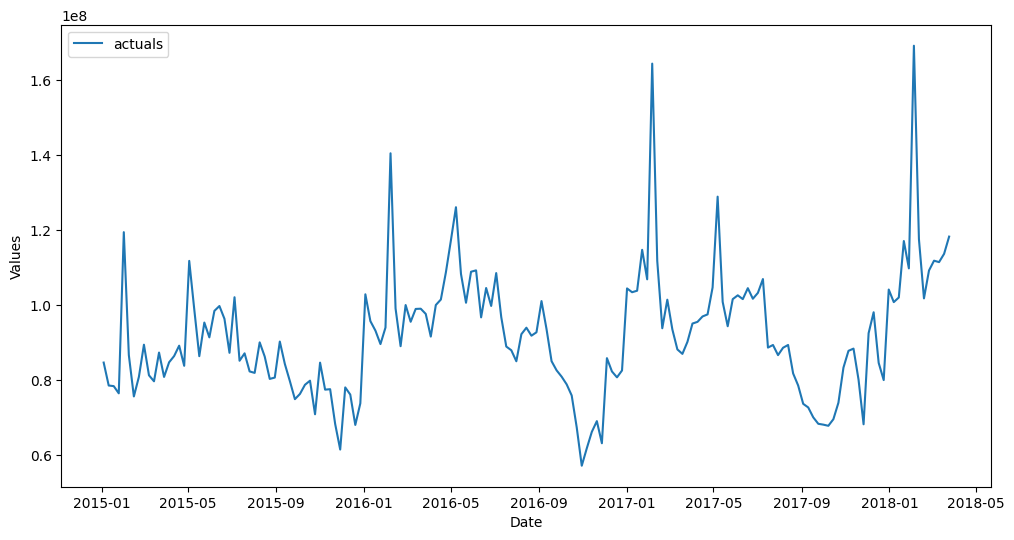

In [7]:
f.plot()
plt.show()

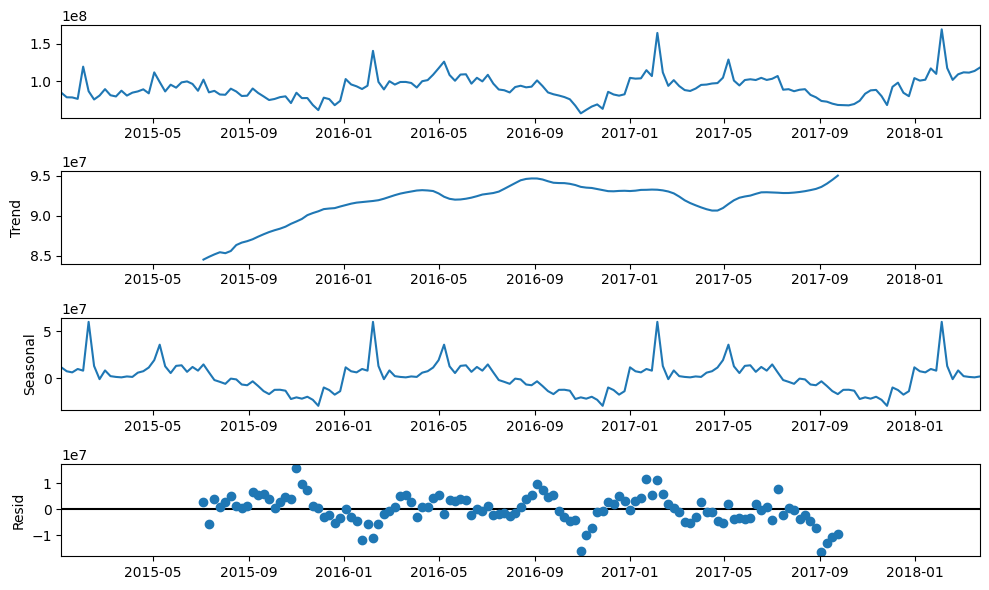

In [8]:
plt.rc("figure",figsize=(10,6))
f.seasonal_decompose().plot()
plt.show()

C:\Users\michaelkeith\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


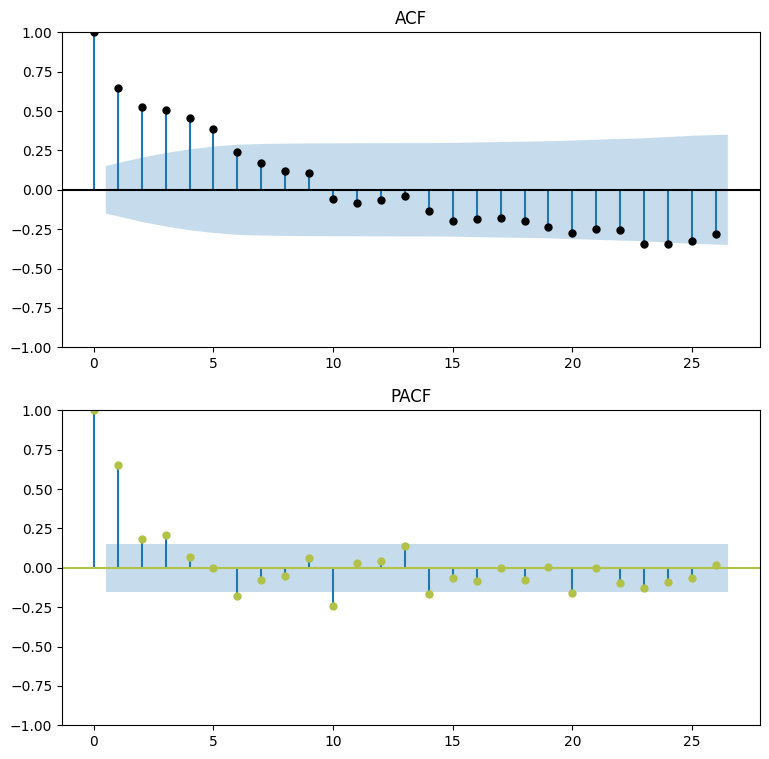

In [9]:
figs, axs = plt.subplots(2, 1,figsize=(9,9))
f.plot_acf(ax=axs[0],title='ACF',lags=26,color='black')
f.plot_pacf(ax=axs[1],title='PACF',lags=26,color='#B2C248')
plt.show()

### Parameterize the `Forecaster` Object

#### Set Test Length
- Starting in scalecast version 0.16.0, you can skip model testing by setting a test length of 0.
- In this example, all models will be tested on the last 15% of the observed values in the dataset.

In [10]:
f.set_test_length(.15)

#### Tell the Object to Evaluate Confidence Intervals
- This only works if there is a test set specified and it is of a sufficient size.
- See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.eval_cis).
- See the [example](https://scalecast-examples.readthedocs.io/en/latest/misc/cis/cis.html).

In [11]:
# default args below
f.eval_cis(
    mode = True, # tell the object to evaluate intervals
    cilevel = .95, # 95% confidence level
)

#### Specify Model Inputs

##### Trend

In [12]:
f.add_time_trend()

##### Seasonality

In [13]:
f.add_seasonal_regressors('week',raw=False,sincos=True)

##### Autoregressive Terms / Series Lags

In [14]:
f.add_ar_terms(13)

In [15]:
f

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13']
    Differenced=0
    TestLength=25
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

### Run Models
- See the [available models](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html).
- See the [blog post](https://medium.com/towards-data-science/expand-your-time-series-arsenal-with-these-models-10c807d37558).
- The `dynamic_testing` argument for all of these will be 13 -- test-set results will then be in terms of rolling averages of 13-step forecasts, which is also our forecast length.

#### Linear Scikit-Learn Models

In [16]:
f.set_estimator('mlr')
f.manual_forecast(dynamic_testing=13)

In [17]:
f.set_estimator('lasso')
f.manual_forecast(alpha=0.2,dynamic_testing=13)

In [18]:
f.set_estimator('ridge')
f.manual_forecast(alpha=0.2,dynamic_testing=13)

In [19]:
f.set_estimator('elasticnet')
f.manual_forecast(alpha=0.2,l1_ratio=0.5,dynamic_testing=13)

In [20]:
f.set_estimator('sgd')
f.manual_forecast(alpha=0.2,l1_ratio=0.5,dynamic_testing=13)

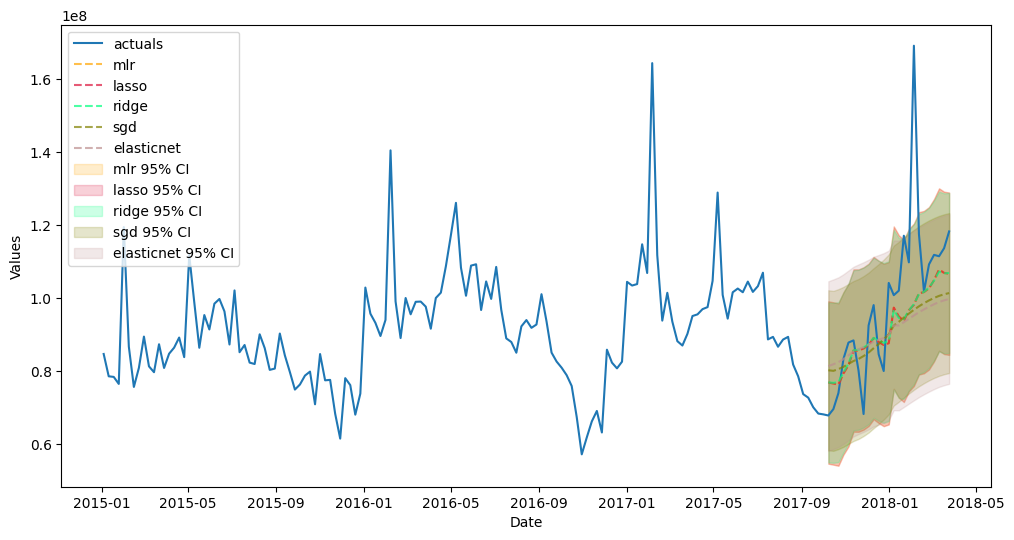

In [21]:
f.plot_test_set(ci=True,models=['mlr','lasso','ridge','elasticnet','sgd'],order_by='LevelTestSetMAPE')
plt.show()

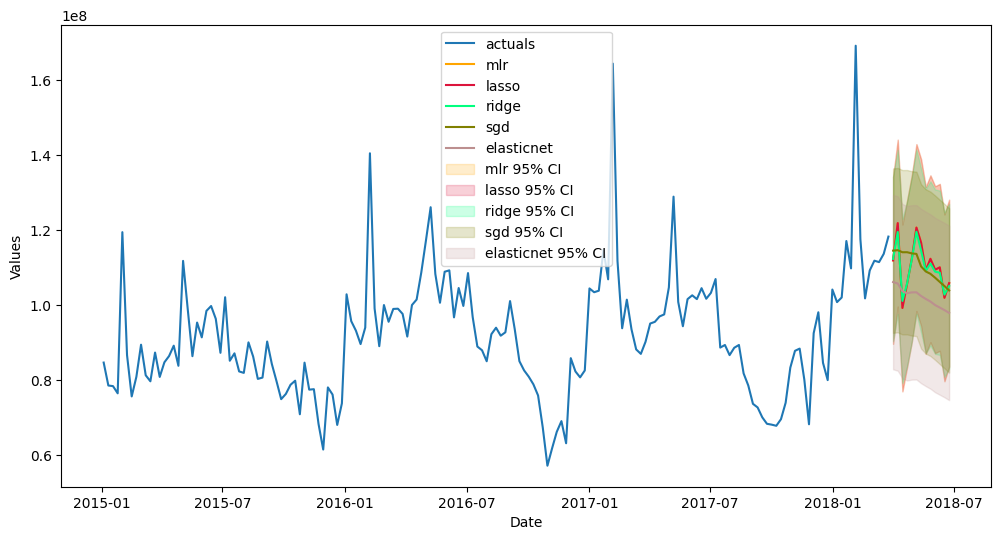

In [22]:
f.plot(ci=True,models=['mlr','lasso','ridge','elasticnet','sgd'],order_by='LevelTestSetMAPE')
plt.show()

#### Non-linear Scikit-Learn Models

In [23]:
f.set_estimator('rf')
f.manual_forecast(max_depth=2,dynamic_testing=13)

In [24]:
f.set_estimator('gbt')
f.manual_forecast(max_depth=2,dynamic_testing=13)

In [25]:
f.set_estimator('xgboost')
f.manual_forecast(gamma=1,dynamic_testing=13)

In [26]:
f.set_estimator('lightgbm')
f.manual_forecast(max_depth=2,dynamic_testing=13)

In [27]:
f.set_estimator('knn')
f.manual_forecast(n_neighbors=5,dynamic_testing=13)

In [28]:
f.set_estimator('mlp')
f.manual_forecast(hidden_layer_sizes=(50,50),solver='lbfgs',dynamic_testing=13)

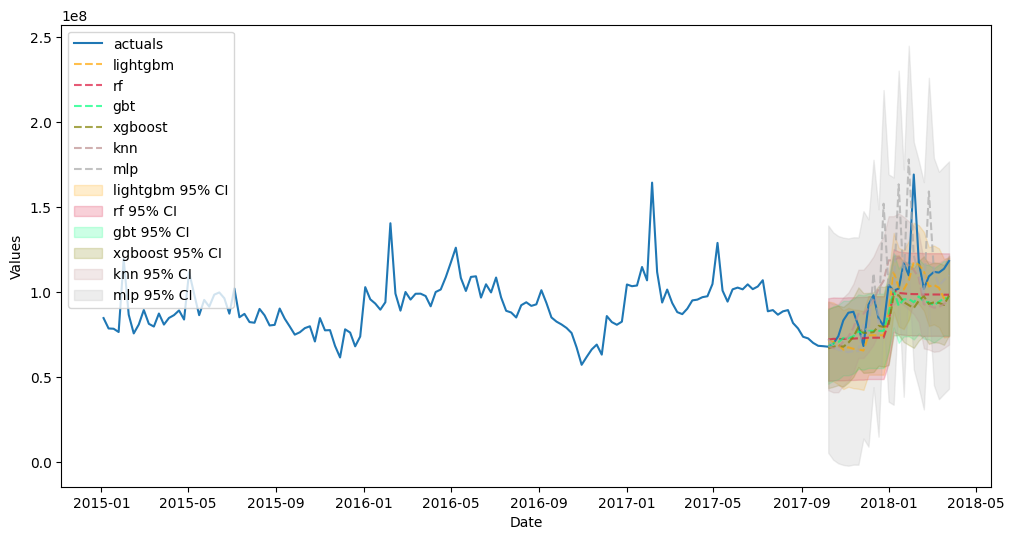

In [29]:
f.plot_test_set(ci=True,models=['rf','gbt','xgboost','lightgbm','knn','mlp'],order_by='LevelTestSetMAPE')
plt.show()

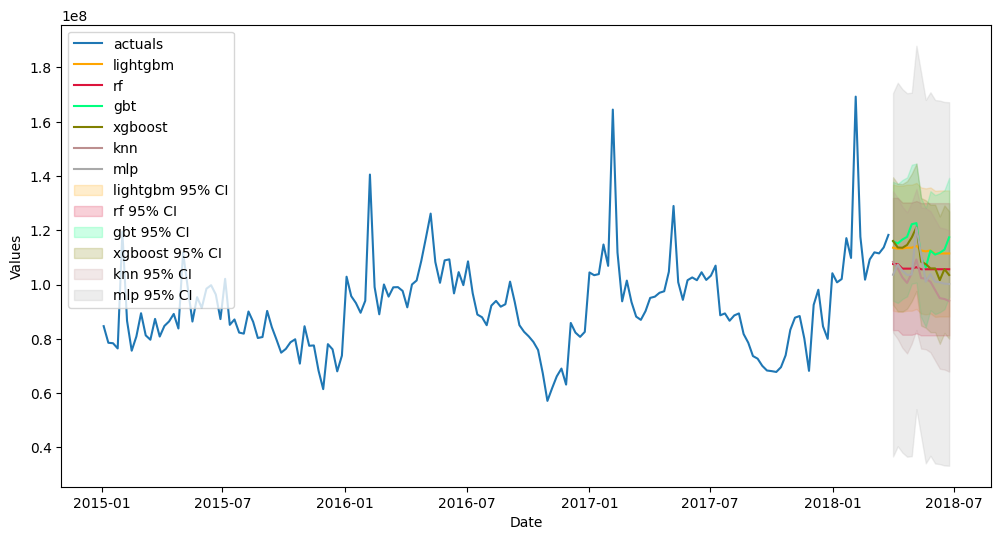

In [30]:
f.plot(ci=True,models=['rf','gbt','xgboost','lightgbm','knn','mlp'],order_by='LevelTestSetMAPE')
plt.show()

#### Stacking Models

##### Custom Stacking Model

In [31]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [32]:
f.add_sklearn_estimator(StackingRegressor,'stacking')

In [33]:
estimators = [
    ('elasticnet',ElasticNet(alpha=0.2)),
    ('xgboost',XGBRegressor(gamma=1)),
    ('gbt',GradientBoostingRegressor(max_depth=2)),
]

final_estimator = LGBMRegressor()

f.set_estimator('stacking')
f.manual_forecast(
    estimators=estimators,
    final_estimator=final_estimator,
    dynamic_testing=13
)

##### MLP Stack from scalecast
- [auxmodels.mlp_stack](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#module-src.scalecast.auxmodels.mlp_stack)

In [34]:
from scalecast.auxmodels import mlp_stack

In [35]:
mlp_stack(f,model_nicknames=['elasticnet','lightgbm','xgboost','knn'],dynamic_testing=13)

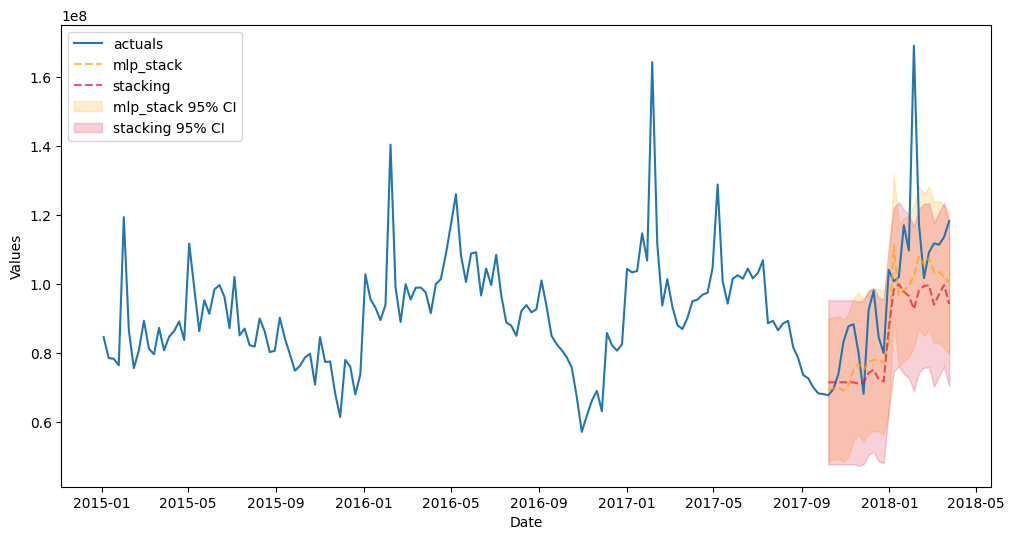

In [36]:
f.plot_test_set(models=['stacking','mlp_stack'],ci=True,order_by='LevelTestSetMAPE')
plt.show()

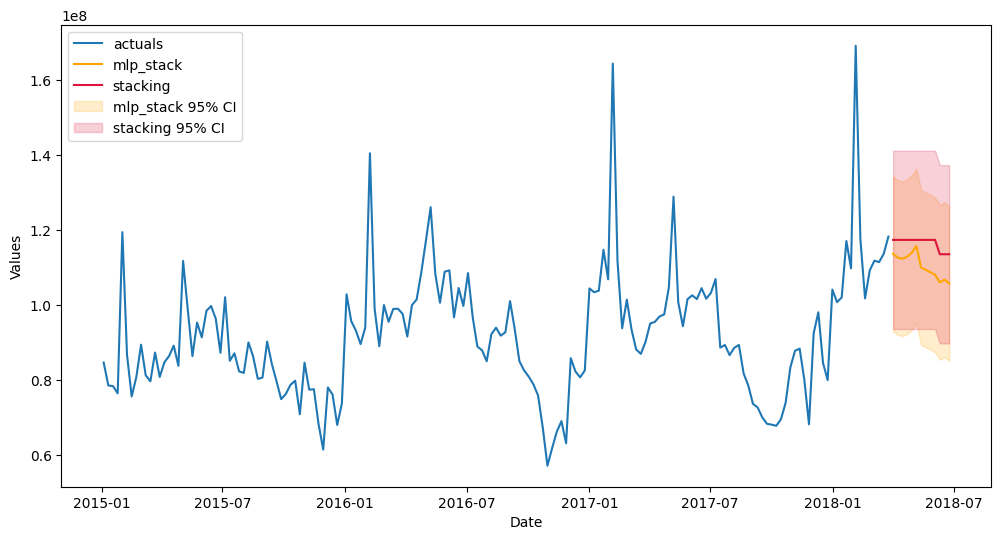

In [37]:
f.plot(models=['stacking','mlp_stack'],ci=True,order_by='LevelTestSetMAPE')
plt.show()

#### ARIMA
- [auxmodels.auto_arima](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#module-src.scalecast.auxmodels.auto_arima)

In [38]:
from scalecast.auxmodels import auto_arima

In [39]:
auto_arima(f,m=52)

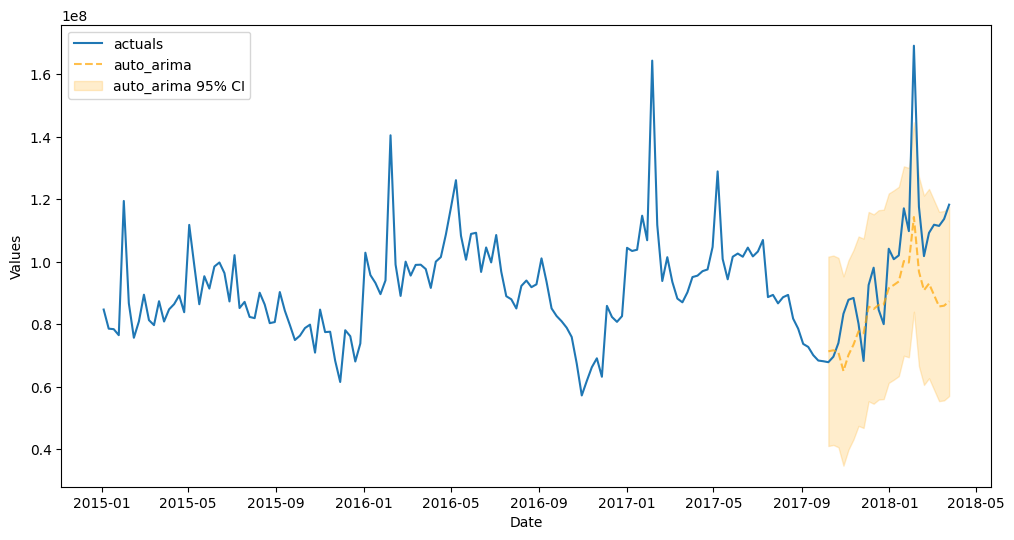

In [40]:
f.plot_test_set(models='auto_arima',ci=True)
plt.show()

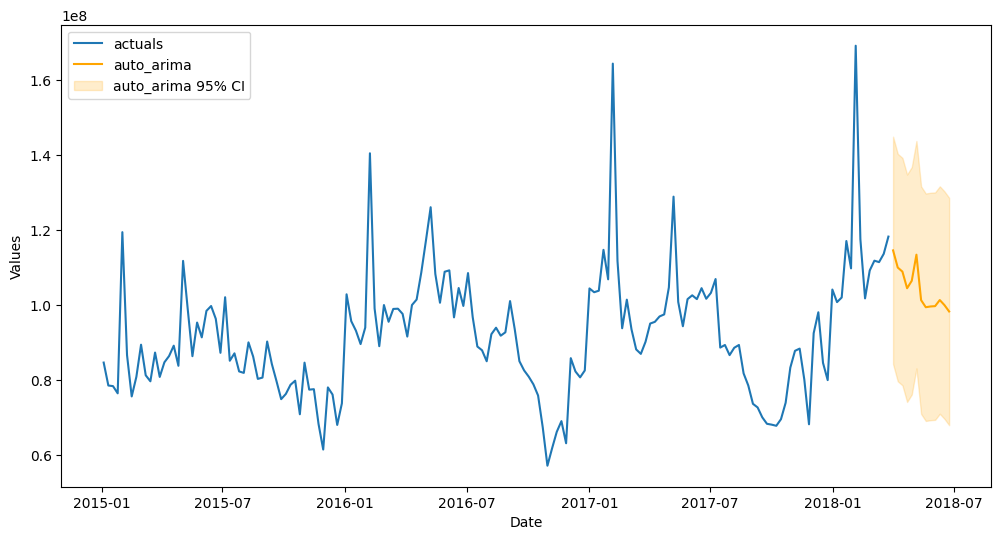

In [41]:
f.plot(models='auto_arima',ci=True)
plt.show()

#### Prophet

In [42]:
f.set_estimator('prophet')
f.manual_forecast()

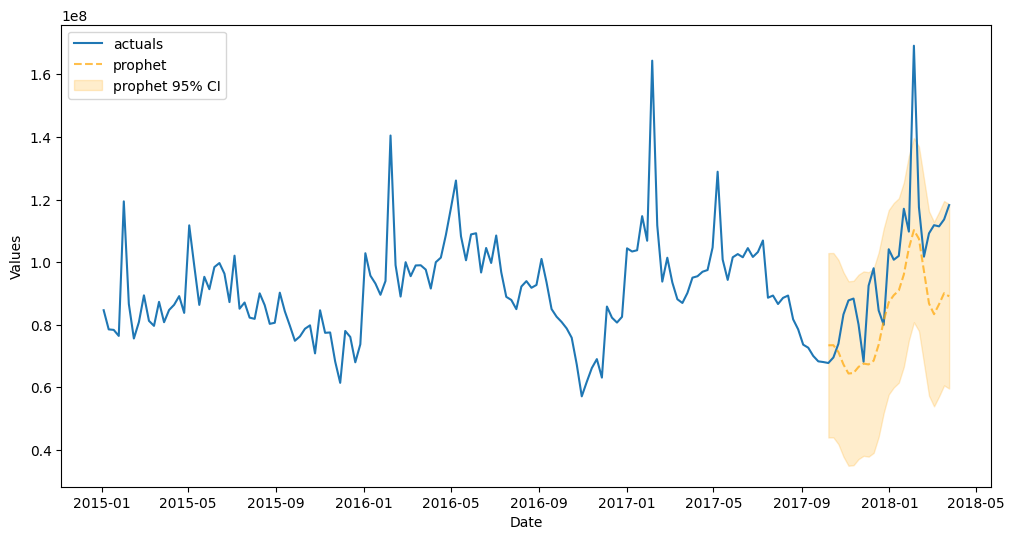

In [43]:
f.plot_test_set(models='prophet',ci=True)
plt.show()

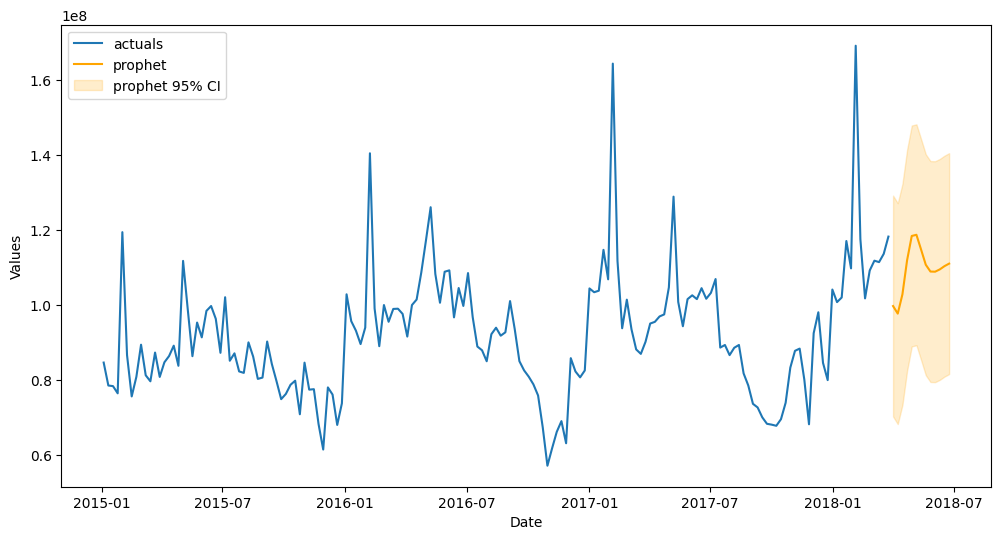

In [44]:
f.plot(models='prophet',ci=True)
plt.show()

Other univariate models available: [Holt-Winters Exponential Smoothing](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_hwes), [LSTM](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_lstm), [RNN](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_rnn), [Silverkite](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_silverkite), [Theta](https://scalecast.readthedocs.io/en/latest/Forecaster/_forecast.html#module-src.scalecast.Forecaster.Forecaster._forecast_theta).

Working on: N-Beats, N-Hits, Genetic Algorithm.

## Multivariate Forecasting

### Load the `MVForecaster` Object
- This object extends the univariate approach to several series, with many of the same plotting and reporting features available.
- [Documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html)

In [45]:
from scalecast.MVForecaster import MVForecaster

In [46]:
price = data.groupby('Date')['AveragePrice'].mean()

fvol = Forecaster(y=volume,current_dates=volume.index,future_dates=13)
fprice = Forecaster(y=price,current_dates=price.index,future_dates=13)

fvol.add_time_trend()
fvol.add_seasonal_regressors('week',raw=False,sincos=True)

mvf = MVForecaster(
    fvol,
    fprice,
    merge_Xvars='union',
    names=['volume','price'],
)

mvf

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['volume', 'price']
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    TestLength=0
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    BootstrapSamples=100
    CurrentEstimator=mlr
    OptimizeOn=mean
    GridsFile=MVGrids
)

### Exploratory Data Analysis

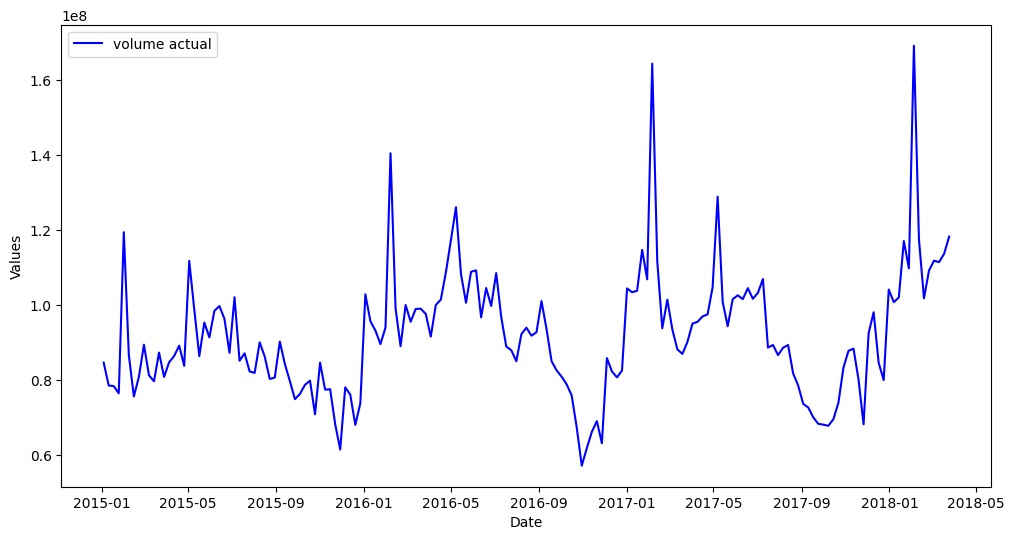

In [47]:
mvf.plot(series='volume')
plt.show()

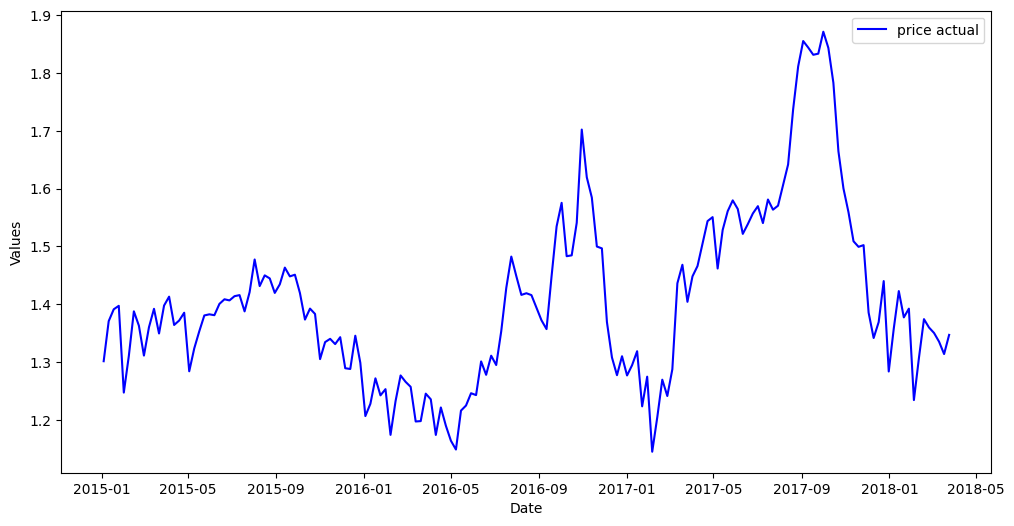

In [48]:
mvf.plot(series='price')
plt.show()

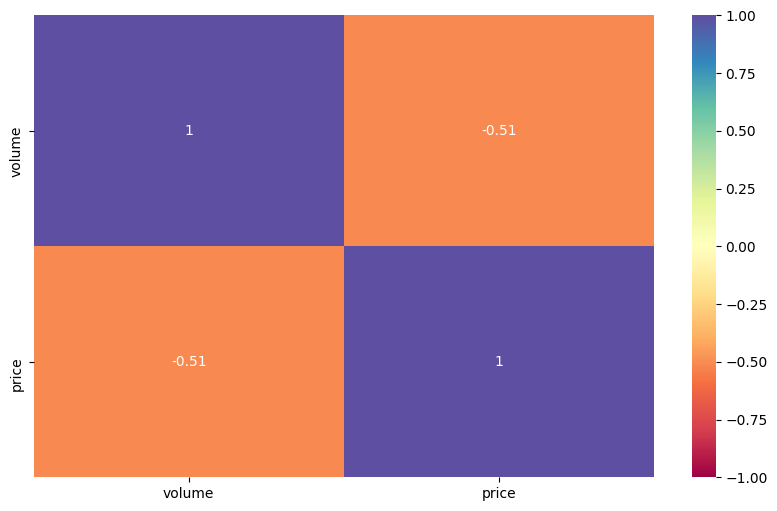

In [49]:
mvf.corr(disp='heatmap',cmap='Spectral',annot=True,vmin=-1,vmax=1)
plt.show()

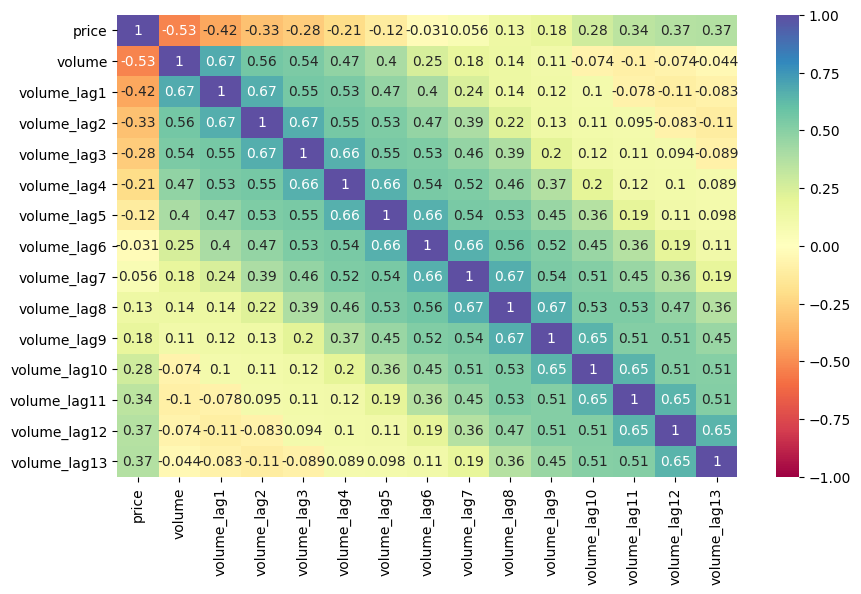

In [50]:
mvf.corr_lags(y='price',x='volume',disp='heatmap',cmap='Spectral',annot=True,vmin=-1,vmax=1,lags=13)
plt.show()

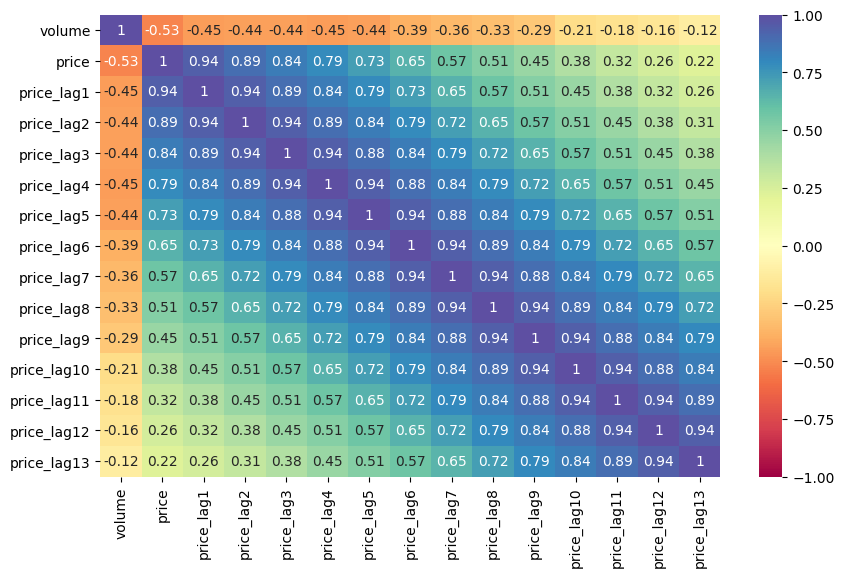

In [51]:
mvf.corr_lags(y='volume',x='price',disp='heatmap',cmap='Spectral',annot=True,vmin=-1,vmax=1,lags=13)
plt.show()

### Parameterize the `MVForecaster` Object
- Starting in scalecast version 0.16.0, you can skip model testing by setting a test length of 0.
- In this example, all models will be tested on the last 15% of the observed values in the dataset.
- We will also have model optimization select hyperparemeters based on what predicts the volume series, rather than the price series, or an average of the two (which is the default), best.
- [Custom optimization](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.add_optimizer_func) functions are available.

In [52]:
mvf.set_test_length(.15)
mvf.set_optimize_on('volume') # we care more about predicting volume and price is just used to make those predictions more accurate
# by default, the optimizer uses an average scoring of all series in the MVForecaster object
mvf.eval_cis() # tell object to evaluate cis

mvf

MVForecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    N_series=2
    SeriesNames=['volume', 'price']
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    TestLength=25
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=mlr
    OptimizeOn=volume
    GridsFile=MVGrids
)

### Run Models
- Uses scikit-learn models and APIs only.
- See the adapted [VECM model](https://scalecast.readthedocs.io/en/latest/Forecaster/Auxmodels.html#vecm) for this object.

#### ElasticNet

In [53]:
mvf.set_estimator('elasticnet')
mvf.manual_forecast(alpha=0.2,dynamic_testing=13,lags=13)

#### XGBoost

In [54]:
mvf.set_estimator('xgboost')
mvf.manual_forecast(gamma=1,dynamic_testing=13,lags=13)

#### MLP Stack

In [55]:
mlp_stack(mvf,model_nicknames=['elasticnet','xgboost'],lags=13)

In [56]:
mvf.set_best_model(determine_best_by='LevelTestSetMAPE')

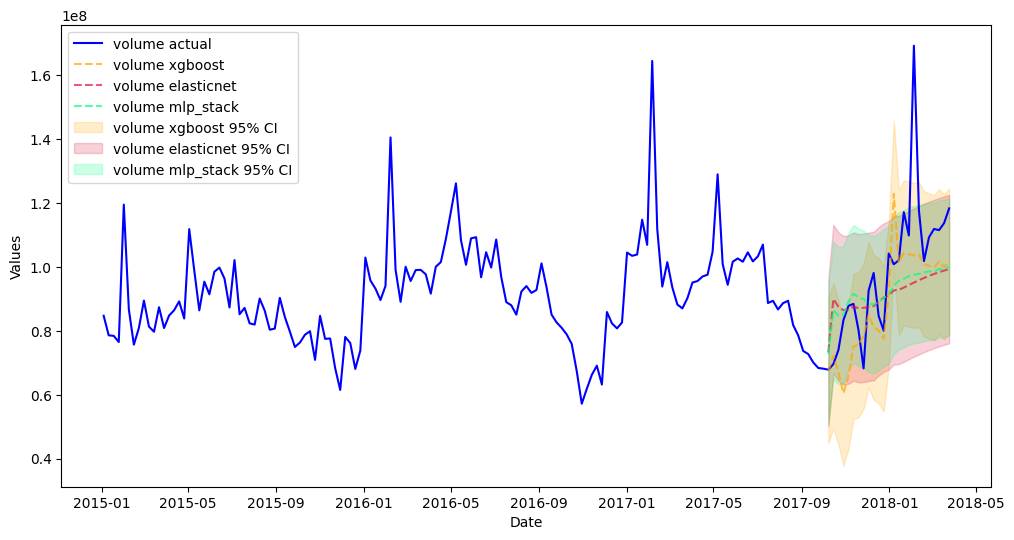

In [57]:
mvf.plot_test_set(ci=True,series='volume',put_best_on_top=True)
plt.show()

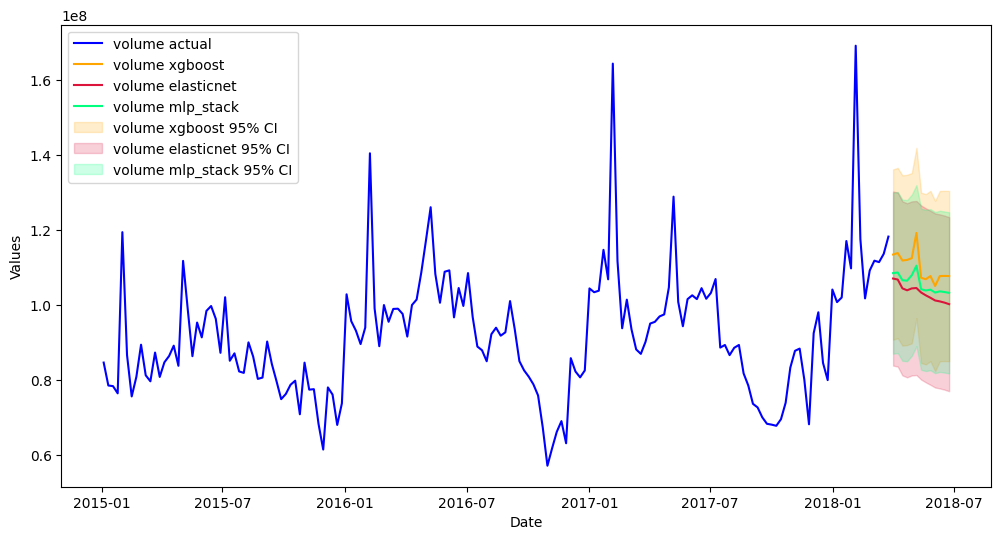

In [58]:
mvf.plot(ci=True,series='volume',put_best_on_top=True)
plt.show()

Probabalistic forecasting for creating confidence intervals is currently being worked on in the MVForecaster object, but until that is done, the backtested interval also works well:

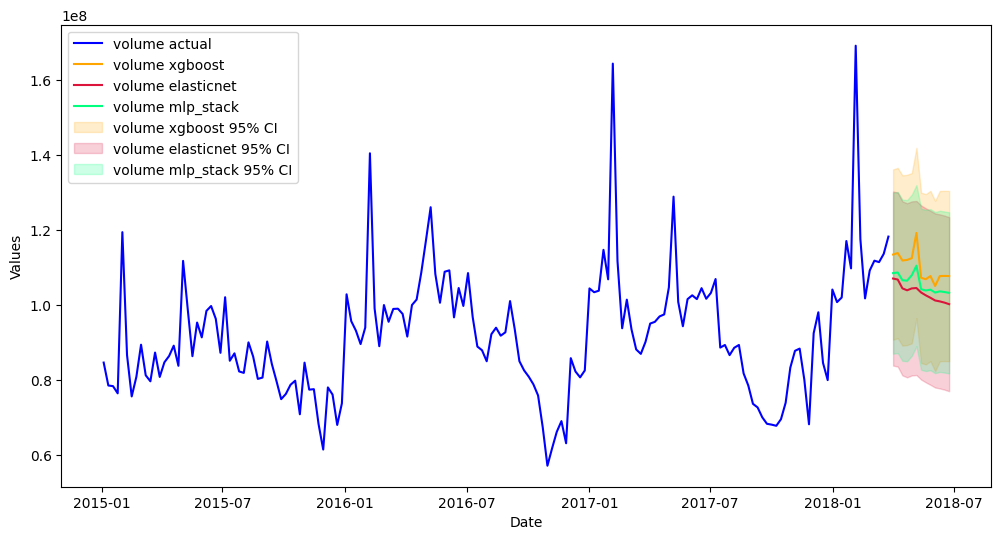

In [59]:
mvf.plot(ci=True,series='volume',put_best_on_top=True)
plt.show()

## Validate Best Model
- The following methods are also available in `Forecaster`.
- See the documentation for [Forecaster](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.backtest) or for [MVForecaster](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.backtest)

In [60]:
mvf.backtest('xgboost')

In [61]:
mvf.export_backtest_metrics('xgboost')

iter1            iter2            iter3  \
series metric                                                      
volume RMSE    22571912.445691  24301869.773979  23577797.355954   
       MAE     17918055.267692  19932967.945385       18433623.1   
       R2            -0.790795        -0.615428        -0.337518   
       MAPE           0.147097         0.166938         0.154453   
price  RMSE           0.110015         0.057176         0.055071   
       MAE            0.099336         0.043919         0.039703   
       R2            -4.413593        -0.122884        -0.074821   
       MAPE           0.075354         0.033255         0.030042   

                         iter4            iter5            iter6  \
series metric                                                      
volume RMSE    23428333.447863  24920250.296542  22289723.627243   
       MAE         15851576.65  21150593.391538  19062131.378462   
       R2            -0.295553        -0.413758         0.084396   
       MAPE           0.130374         0.193837         0.178687   
price  RMSE            0.05483         0.101134         0.099533   
       MAE            0.039221         0.085776         0.083597   
       R2            -0.071422        -2.563191        -1.269456   
       MAPE           0.029676         0.064914         0.062991   

                         iter7            iter8            iter9  \
series metric                                                      
volume RMSE    22444928.884464  22971724.038989  17509082.415482   
       MAE         18609224.65       18141630.5  15786053.163077   
       R2             0.134117          0.07693        -0.793457   
       MAPE           0.174724         0.170199         0.165961   
price  RMSE           0.150546         0.140426         0.118688   
       MAE            0.130668         0.115912         0.098581   
       R2             -3.05448        -2.138118        -1.419744   
       MAPE           0.098092          0.08677         0.072079   

                        iter10          mean  
series metric                                 
volume RMSE    14298896.033942  2.183145e+07  
       MAE     13295634.124615  1.781815e+07  
       R2            -0.330038 -3.281105e-01  
       MAPE           0.142389  1.624658e-01  
price  RMSE           0.116497  1.003916e-01  
       MAE            0.096154  8.328677e-02  
       R2             -0.68432 -1.581203e+00  
       MAPE           0.069676  6.228473e-02

### Break Back into Forecaster Objects
- You can then add univariate models to these objects to compare with the models run multivariate.

In [62]:
from scalecast.util import break_mv_forecaster

In [63]:
fvol, fprice = break_mv_forecaster(mvf)

In [64]:
fvol

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    Differenced=0
    TestLength=25
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=['elasticnet', 'xgboost', 'mlp_stack']
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [65]:
fprice

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['t', 'weeksin', 'weekcos']
    Differenced=0
    TestLength=25
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=['elasticnet', 'xgboost', 'mlp_stack']
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

## Transformations
- One of the most effective way to boost forecasting power is with transformations.
- Transformations include:
  - [Log](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.LogTransform)
  - Scaling
    - [Standard](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.ScaleTransform)
    - [MinMax](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.MinMaxTransform)
  - [Differencing](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.DiffTransform)
  - [Detrending](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.DetrendTransform)
  - [Custom Functions](https://scalecast.readthedocs.io/en/latest/Forecaster/SeriesTransformer.html#src.scalecast.SeriesTransformer.SeriesTransformer.Transform)
- All transformations have a corresponding revert function.
- See the [blog post](https://medium.com/towards-data-science/time-series-transformations-and-reverting-made-easy-f4f768c18f63).

In [66]:
from scalecast.SeriesTransformer import SeriesTransformer

In [67]:
f_trans = Forecaster(y=volume,current_dates=volume.index,future_dates=13)

In [68]:
f_trans.set_test_length(.15)
f_trans.set_validation_length(13)

In [69]:
transformer = SeriesTransformer(f_trans)

In [70]:
# these will all be reverted later after forecasts have been called
f_trans = transformer.DiffTransform(1)
f_trans = transformer.DiffTransform(52)
f_trans = transformer.DetrendTransform()

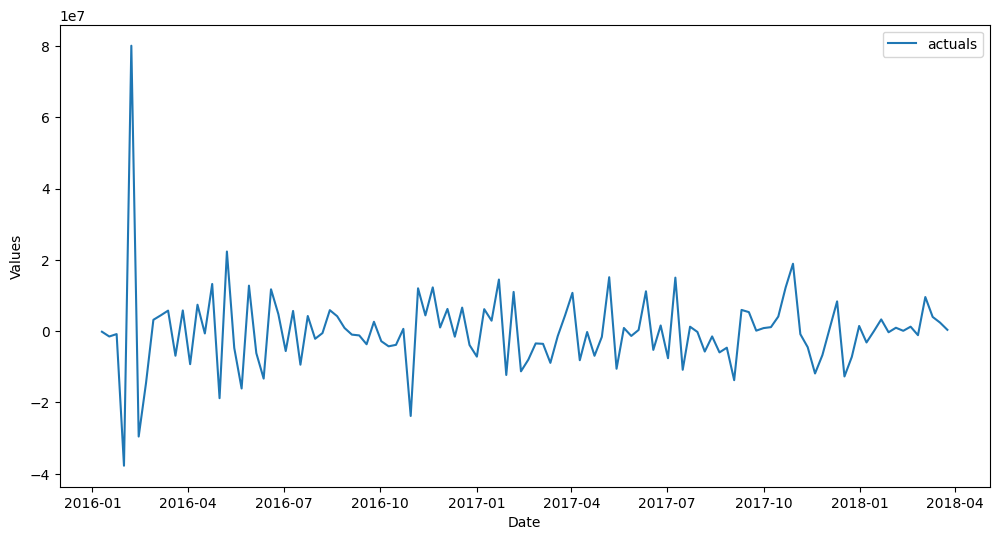

In [71]:
f_trans.plot()
plt.show()

In [72]:
f_trans.add_time_trend()
f_trans.add_seasonal_regressors('week',sincos=True,raw=False)
f_trans.add_ar_terms(13)

In [73]:
f_trans.set_estimator('xgboost')
f_trans.manual_forecast(gamma=1,dynamic_testing=13)

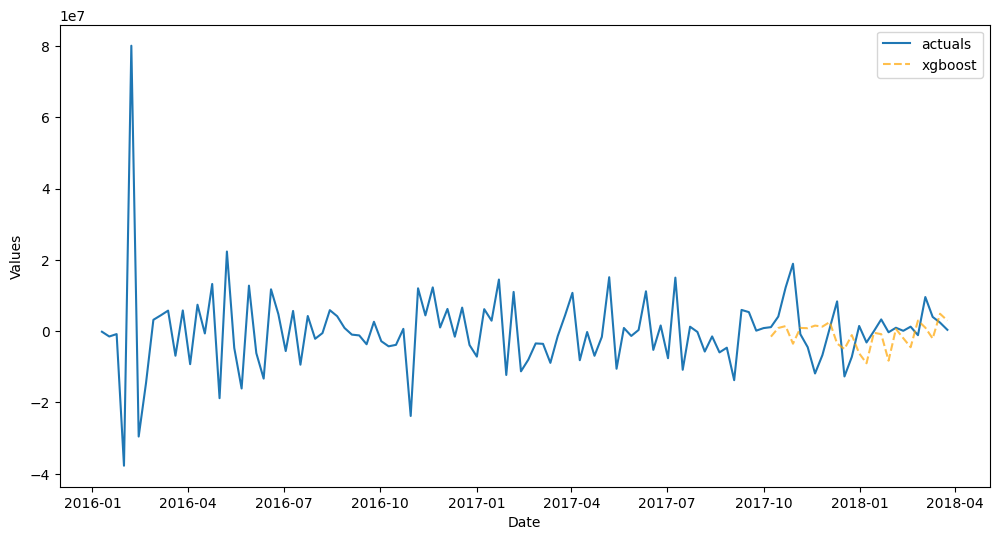

In [74]:
f_trans.plot_test_set()
plt.show()

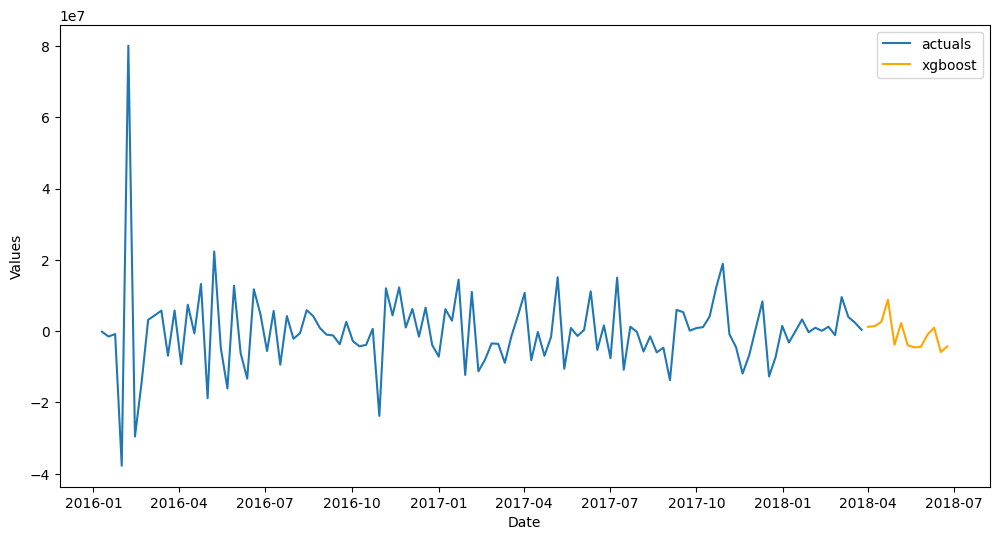

In [75]:
f_trans.plot()
plt.show()

In [76]:
# call revert functions in the opposite order as how they were called when transforming
f_trans = transformer.DetrendRevert()
f_trans = transformer.DiffRevert(52)
f_trans = transformer.DiffRevert(1)

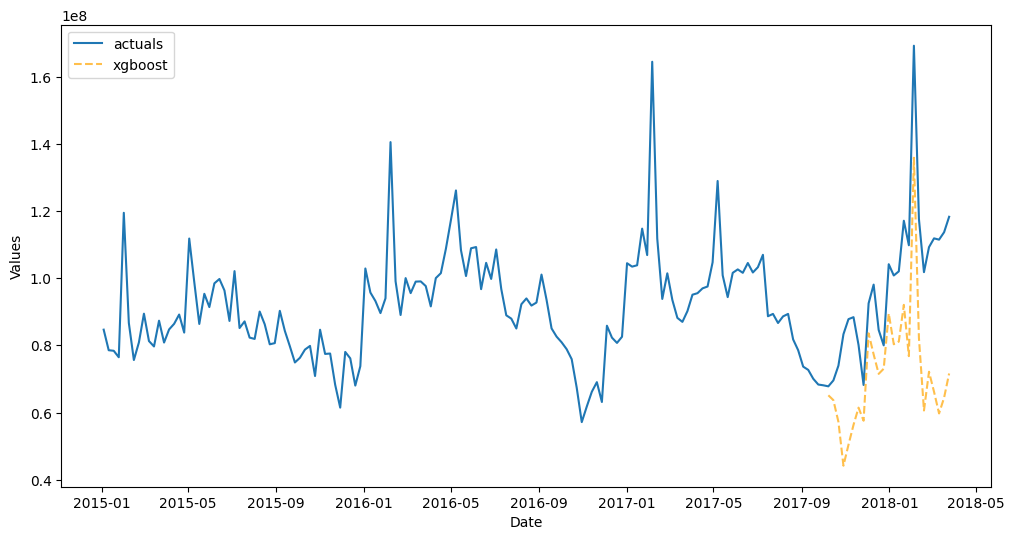

In [77]:
f_trans.plot_test_set()
plt.show()

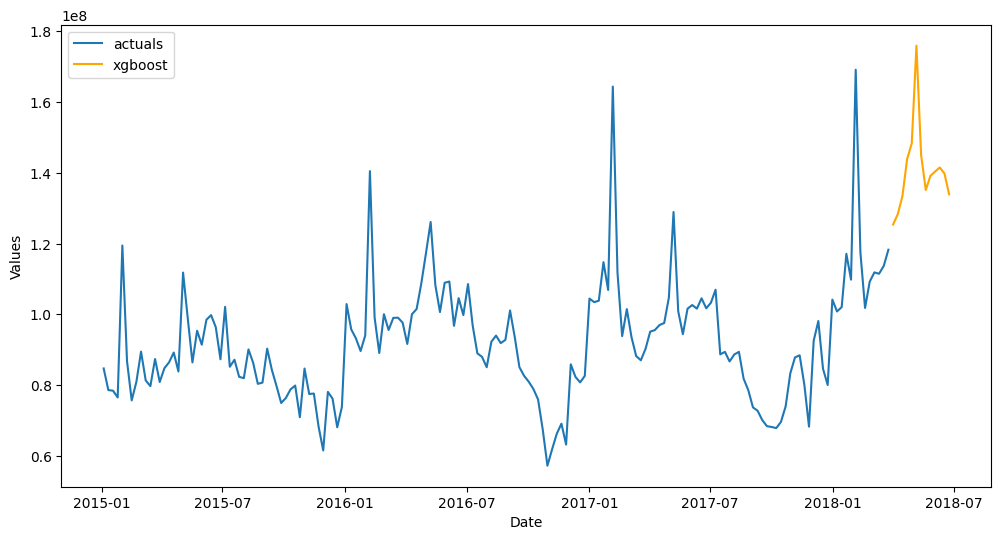

In [78]:
f_trans.plot()
plt.show()

## Pipelines
- These are objects similar to scikit-learn pipelines that offer readable and streamlined code for transforming, forecasting, and reverting.
- See the [Pipeline object documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html).

In [79]:
from scalecast.Pipeline import Transformer, Reverter, Pipeline, MVPipeline

In [80]:
f_pipe = Forecaster(y=volume,current_dates=volume.index,future_dates=13)
f_pipe.set_test_length(.15)

In [81]:
def forecaster(f):
    f.add_time_trend()
    f.add_seasonal_regressors('week',raw=False,sincos=True)
    f.add_ar_terms(13)
    f.set_estimator('lightgbm')
    f.manual_forecast(max_depth=2)

In [82]:
transformer = Transformer(
    transformers = [
        ('DiffTransform',1),
        ('DiffTransform',52),
        ('DetrendTransform',)
    ]
)

reverter = Reverter(
    reverters = [
        ('DetrendRevert',),
        ('DiffRevert',52),
        ('DiffRevert',1)
    ],
    base_transformer = transformer,
)

In [83]:
reverter

Reverter(
  reverters = [
    ('DetrendRevert',),
    ('DiffRevert', 52),
    ('DiffRevert', 1)
  ],
  base_transformer = Transformer(
  transformers = [
    ('DiffTransform', 1),
    ('DiffTransform', 52),
    ('DetrendTransform',)
  ]
)
)

In [84]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f_pipe = pipeline.fit_predict(f_pipe)

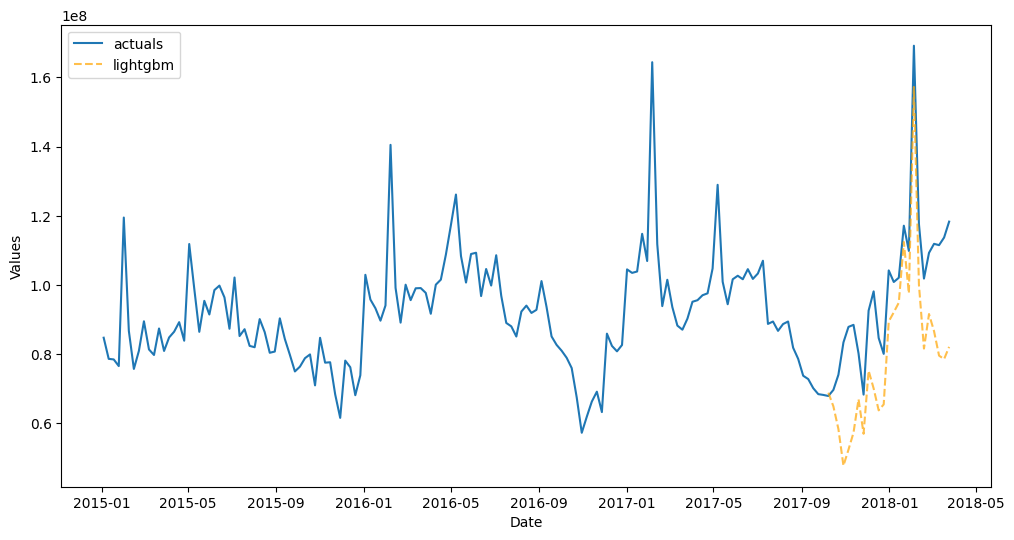

In [85]:
f_pipe.plot_test_set()
plt.show()

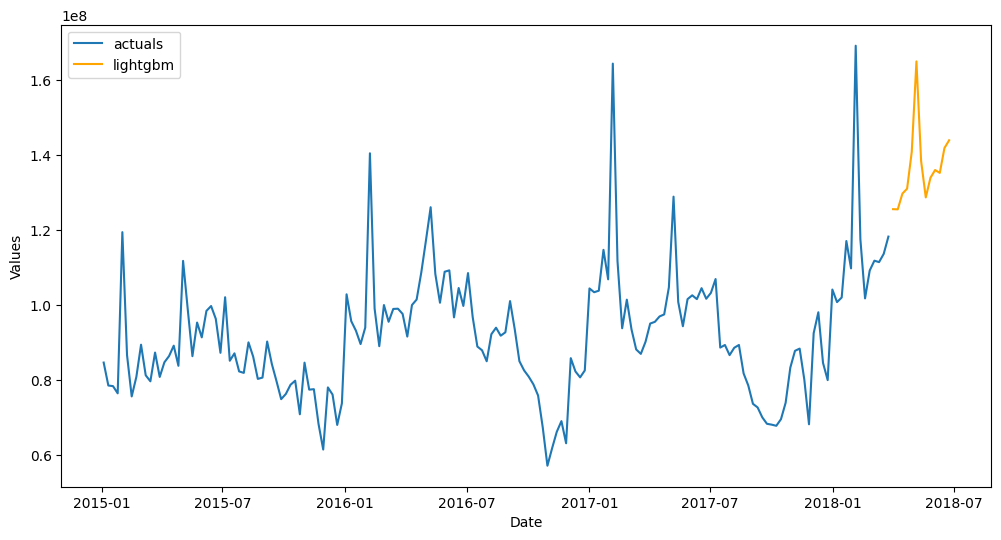

In [86]:
f_pipe.plot()
plt.show()

## Fully Automated Pipelines
- We can automate the construction of pipelines, the selection of input variables, and tuning of models with cross validation on a grid search for each model using files in the working directory called `Grids.py` for univariate forecasting and `MVGrids.py` for multivariate. Default grids can be downloaded from scalecast.

### Automated Univariate Pipelines
- [Documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.Pipeline)

In [87]:
from scalecast import GridGenerator
from scalecast.util import find_optimal_transformation

In [88]:
GridGenerator.get_example_grids()

In [89]:
f_pipe_aut = Forecaster(y=volume,current_dates=volume.index,future_dates=13)
f_pipe_aut.set_test_length(.15)

In [90]:
def forecaster_aut(f,models):
    f.auto_Xvar_select(
        estimator='elasticnet',
        monitor='TestSetMAE',
        alpha=0.2,
        irr_cycles = [26],
    )
    f.tune_test_forecast(
        models,
        cross_validate=True,
        k=3,
        # dynamic tuning = 13 means we will hopefully find a model that is optimized to predict 13 steps
        dynamic_tuning=13,
        dynamic_testing=13,
    )
    f.set_estimator('combo')
    f.manual_forecast()

### util.find_optimal_transformation
In this function, the following transformations are searched for:  
- Detrending  
- Box-Cox  
- First Differencing  
- Seasonal Differencing  
- Scaling  

The optimal set of transformations are returned based on best estimated out-of-sample performance on the test set. Therefore, running this function introduces leakage into the test set, but it can still be a good addition to an automated pipeline, depending on the application. Which and the order of transfomations to search through are configurable. How performance is measured, the parameters specific to a given transformation, and several other paramters are also configurable. See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#module-src.scalecast.util.find_optimal_transformation).

In [91]:
transformer_aut, reverter_aut = find_optimal_transformation(
    f_pipe_aut,
    lags = 13,
    m = 52,
    monitor = 'TestSetMAE',
    estimator = 'elasticnet',
    alpha = 0.2,
    scale_on_train_only = True,
) # returns a Transformer and Reverter object that can be plugged into a larger pipeline

In [92]:
# see the set of transformations that were selected for this series
reverter_aut

Reverter(
  reverters = [
    ('ScaleRevert',),
    ('DiffRevert', 52),
    ('DetrendRevert',)
  ],
  base_transformer = Transformer(
  transformers = [
    ('DetrendTransform', {'poly_order': 2}),
    ('DiffTransform', 52),
    ('ScaleTransform', {'train_only': True})
  ]
)
)

In [93]:
pipeline_aut = Pipeline(
    steps = [
        ('Transform',transformer_aut),
        ('Forecast',forecaster_aut),
        ('Revert',reverter_aut),
    ]
)

f_pipe_aut = pipeline_aut.fit_predict(
    f_pipe_aut,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
        'lightgbm',
        'knn',
    ],
)

In [94]:
f_pipe_aut

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2018-03-25T00:00:00.000000000
    Freq=W-SUN
    N_actuals=169
    ForecastLength=13
    Xvars=['weeksin', 'weekcos', 'monthsin', 'monthcos', 'quartersin', 'quartercos']
    Differenced=0
    TestLength=25
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=['mlr', 'elasticnet', 'xgboost', 'lightgbm', 'knn', 'combo']
    CILevel=None
    BootstrapSamples=100
    CurrentEstimator=combo
    GridsFile=Grids
)

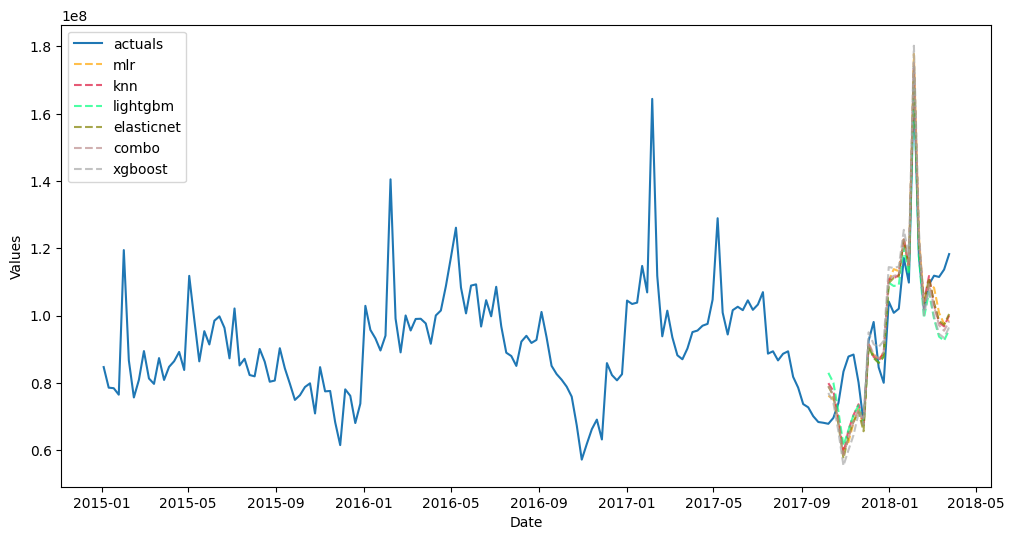

In [95]:
f_pipe_aut.plot_test_set(order_by='LevelTestSetMAPE')
plt.show()

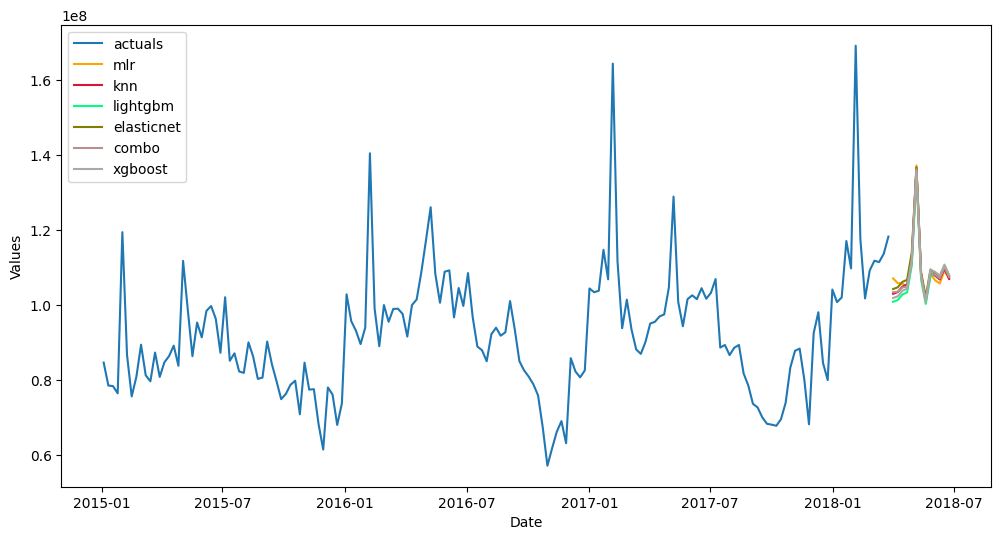

In [96]:
f_pipe_aut.plot(order_by='LevelTestSetMAPE')
plt.show()

### Automated Multivariate Pipelines
- See the [MVPipeline object documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.MVPipeline).

In [97]:
GridGenerator.get_mv_grids()

In [98]:
fvol_aut = Forecaster(
    y=volume,
    current_dates=volume.index,
    future_dates=13,
    test_length = .15,
)
fprice_aut = Forecaster(
    y=price,
    current_dates=price.index,
    future_dates=13,
    test_length = .15,
)

In [99]:
def add_vars(f,**kwargs):
    f.add_seasonal_regressors(
        'month',
        'quarter',
        'week',
        raw=False,
        sincos=True
    )

def mvforecaster(mvf,models):
    mvf.set_optimize_on('volume')
    mvf.tune_test_forecast(
        models,
        cross_validate=True,
        k=2,
        rolling=True,
        dynamic_tuning=13,
        dynamic_testing=13,
    )

In [100]:
transformer_vol, reverter_vol = find_optimal_transformation(
    fvol_aut,
    lags = 13,
    m = 52,
    monitor = 'TestSetMAE',
    estimator = 'elasticnet',
    alpha = 0.2,
    scale_on_train_only = True,
)

In [101]:
# see the set of transformations that were selected for this series
reverter_vol

Reverter(
  reverters = [
    ('ScaleRevert',),
    ('DiffRevert', 52),
    ('DetrendRevert',)
  ],
  base_transformer = Transformer(
  transformers = [
    ('DetrendTransform', {'poly_order': 2}),
    ('DiffTransform', 52),
    ('ScaleTransform', {'train_only': True})
  ]
)
)

In [102]:
transformer_price, reverter_price = find_optimal_transformation(
    fprice_aut,
    lags = 13,
    m = 52,
    monitor = 'TestSetMAE',
    estimator = 'elasticnet',
    alpha = 0.2,
    scale_on_train_only = True,
)

In [103]:
# see the set of transformations that were selected for this series
reverter_price

Reverter(
  reverters = [
    ('DiffRevert', 52),
    ('Revert', <function find_optimal_transformation.<locals>.boxcox_re at 0x000001FF8362D700>, {'lmbda': -0.5})
  ],
  base_transformer = Transformer(
  transformers = [
    ('Transform', <function find_optimal_transformation.<locals>.boxcox_tr at 0x000001FF8362D310>, {'lmbda': -0.5}),
    ('DiffTransform', 52)
  ]
)
)

In [104]:
mvpipeline = MVPipeline(
    steps = [
        ('Transform',[transformer_vol,transformer_price]),
        ('Add Xvars',[add_vars]*2),
        ('Forecast',mvforecaster),
        ('Reverter',[reverter_vol,reverter_price]),
    ],
    test_length = 20,
    cis = True,
    names = ['volume','price'],
)

fvol_aut, fprice_aut = mvpipeline.fit_predict(
    fvol_aut, 
    fprice_aut,
    models=[
        'mlr',
        'elasticnet',
        'xgboost',
        'lightgbm',
        'knn',
    ],
) # returns a tuple of Forecaster objects

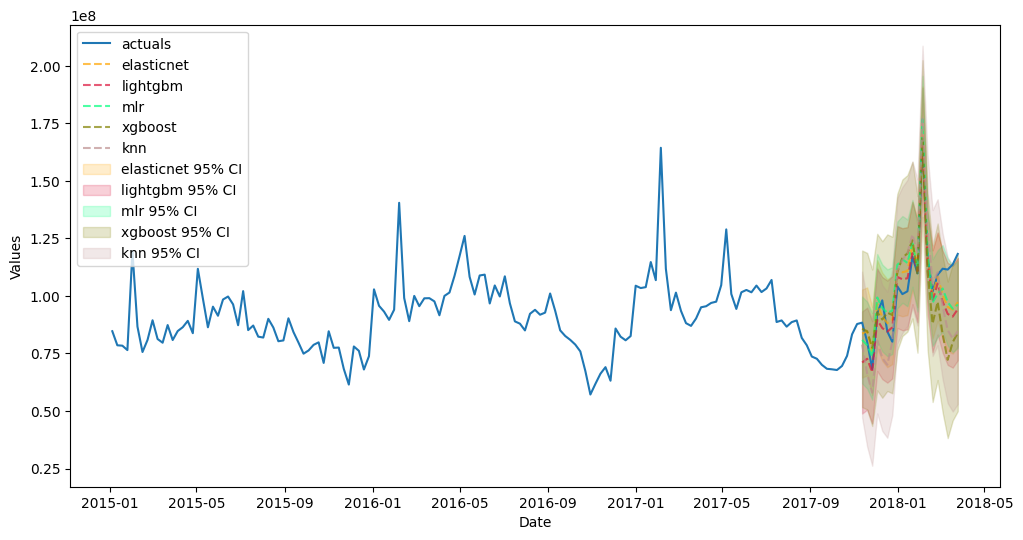

In [105]:
fvol_aut.plot_test_set(order_by='LevelTestSetMAPE',ci=True)
plt.show()

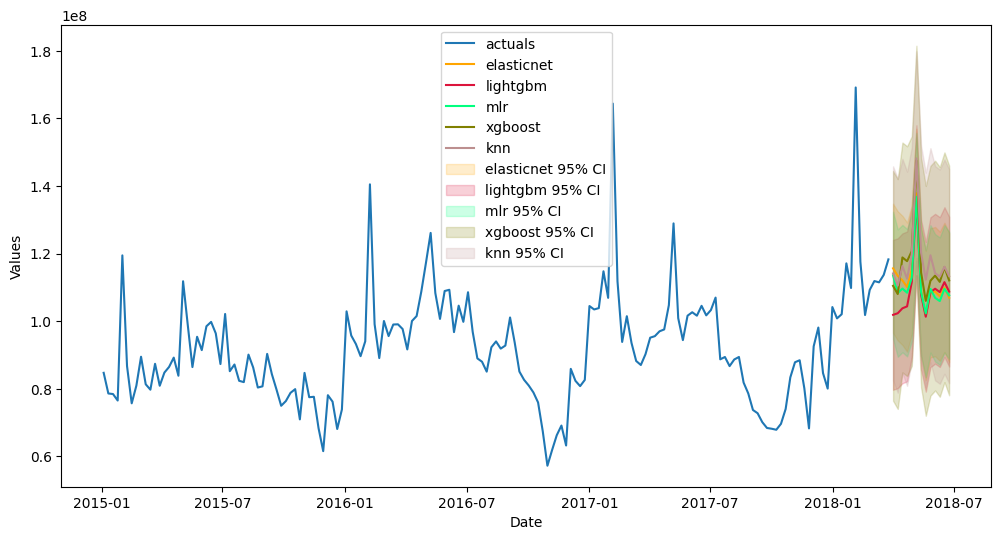

In [106]:
fvol_aut.plot(order_by='LevelTestSetMAPE',ci=True)
plt.show()

## Scaled Automated Forecasting
- We can scale the fully automated approach to many series where we can then access all results through plotting with Jupyter widgets and export functions.
- We produce a separate forecast for avocado sales in each region in our dataset.
- This is done with a univariate approach, but cleverly using the code in this notebook, it could be transformed into a multivariate process where volume and price are forecasted together.

In [107]:
from scalecast.notebook import results_vis
from tqdm.notebook import tqdm

In [108]:
def forecaster_scaled(f,models):
    f.auto_Xvar_select(
        estimator='elasticnet',
        monitor='TestSetMAE',
        alpha=0.2,
        irr_cycles = [26],
    )
    f.tune_test_forecast(
        models,
        dynamic_testing=13,
    )
    f.set_estimator('combo')
    f.manual_forecast()

In [109]:
results_dict = {}
for region in tqdm(data.region.unique()):
    series = data.loc[data['region'] == region].groupby('Date')['Total Volume'].sum()
    f_i = Forecaster(
        y = series,
        current_dates = series.index,
        future_dates = 13,
        test_length = .15,
        validation_length = 13,
        cis = True,
    )
    transformer_i, reverter_i = find_optimal_transformation(
        f_i,
        lags = 13,
        m = 52,
        monitor = 'TestSetMAE',
        estimator = 'elasticnet',
        alpha = 0.2,
    )
    pipeline_i = Pipeline(
        steps = [
            ('Transform',transformer_i),
            ('Forecast',forecaster_scaled),
            ('Revert',reverter_i),
        ]
    )
    f_i = pipeline_i.fit_predict(
        f_i,
        models=[
            'mlr',
            'elasticnet',
            'xgboost',
            'lightgbm',
            'knn',
        ],
    )
    results_dict[region] = f_i

  0%|          | 0/54 [00:00<?, ?it/s]

Run the next two functions locally to see the full functionality of these widgets.

In [110]:
results_vis(results_dict,'test')

Dropdown(description='Time Series:', options=('Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', '…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5, 6), value=1)

Dropdown(description='View Level', options=(True, False), value=True)

Dropdown(description='View Confidence Intervals', options=(True, False), value=True)

Dropdown(description='Order By', options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE', 'LevelI…

Button(description='Select Time Series', style=ButtonStyle())

Output()

In [111]:
results_vis(results_dict)

Dropdown(description='Time Series:', options=('Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', '…

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5, 6), value=1)

Dropdown(description='View Level', options=(True, False), value=True)

Dropdown(description='View Confidence Intervals', options=(True, False), value=True)

Dropdown(description='Order By', options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE', 'LevelI…

Button(description='Select Time Series', style=ButtonStyle())

Output()

## Exporting Results

In [112]:
from scalecast.multiseries import export_model_summaries

### Exporting Results from a Single `Forecaster` Object

In [113]:
results = f.export(cis=True)
results.keys()

dict_keys(['model_summaries', 'all_fcsts', 'test_set_predictions', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [114]:
for k, df in results.items():
    print(f'{k} has these columns : {df.columns}')

model_summaries has these columns : Index(['ModelNickname', 'Estimator', 'Xvars', 'HyperParams', 'Scaler',
       'Observations', 'Tuned', 'CrossValidated', 'DynamicallyTested',
       'Integration', 'TestSetLength', 'TestSetRMSE', 'TestSetMAPE',
       'TestSetMAE', 'TestSetR2', 'CILevel', 'InSampleRMSE', 'InSampleMAPE',
       'InSampleMAE', 'InSampleR2', 'ValidationSetLength', 'ValidationMetric',
       'ValidationMetricValue', 'models', 'weights', 'LevelTestSetRMSE',
       'LevelTestSetMAPE', 'LevelTestSetMAE', 'LevelTestSetR2',
       'LevelInSampleRMSE', 'LevelInSampleMAPE', 'LevelInSampleMAE',
       'LevelInSampleR2', 'best_model'],
      dtype='object')
all_fcsts has these columns : Index(['DATE', 'mlr', 'mlr_upperci', 'mlr_lowerci', 'lasso', 'lasso_upperci',
       'lasso_lowerci', 'ridge', 'ridge_upperci', 'ridge_lowerci',
       'elasticnet', 'elasticnet_upperci', 'elasticnet_lowerci', 'sgd',
       'sgd_upperci', 'sgd_lowerci', 'rf', 'rf_upperci', 'rf_lowerci', 'gbt',
   

In [115]:
results['model_summaries'][['ModelNickname','HyperParams','TestSetMAPE','InSampleMAPE']]

,ModelNickname,HyperParams,TestSetMAPE,InSampleMAPE
0,lightgbm,{'max_depth': 2},0.121612,0.045536
1,ridge,{'alpha': 0.2},0.100123,0.075706
2,mlr,{},0.099241,0.075756
3,lasso,{'alpha': 0.2},0.099241,0.075756
4,mlp_stack,"{'estimators': [('elasticnet', ElasticNet(alph...",0.109964,0.032044
5,knn,{'n_neighbors': 5},0.139001,0.064627
6,sgd,"{'alpha': 0.2, 'l1_ratio': 0.5}",0.119636,0.093431
7,auto_arima,"{'order': (3, 0, 0), 'seasonal_order': (0, 0, ...",0.135889,0.077152
8,elasticnet,"{'alpha': 0.2, 'l1_ratio': 0.5}",0.127014,0.091382
9,rf,{'max_depth': 2},0.127370,0.068275


Other export functions:  
[Forecaster.export_Xvars_df](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_Xvars_df)  
[Forecaster.export_backtest_metrics](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_backtest_metrics)  
[Forecaster.export_backtest_values](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_backtest_values)
[Forecaster.export_feature_importance](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_feature_importance)  
[Forecaster.export_fitted_vals](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_fitted_vals)  
[Forecaster.export_summary_stats](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_summary_stats)  
[Forecaster.export_validation_grid](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.export_validation_grid)  

Other plotting functions:  
[Forecaster.plot_fitted](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.plot_fitted)  
[Forecaster.plot_periodogram](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.plot_periodogram)  

### Exporting Results from a Single `MVForecaster` Object

In [116]:
mvresults = mvf.export(cis=True)
mvresults.keys()

dict_keys(['model_summaries', 'all_fcsts', 'test_set_predictions', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [117]:
for k, df in mvresults.items():
    print(f'{k} has these columns : {df.columns}')

model_summaries has these columns : Index(['Series', 'ModelNickname', 'Estimator', 'Xvars', 'HyperParams', 'Lags',
       'Scaler', 'Observations', 'Tuned', 'CrossValidated',
       'DynamicallyTested', 'Integration', 'TestSetLength', 'TestSetRMSE',
       'TestSetMAPE', 'TestSetMAE', 'TestSetR2', 'LastTestSetPrediction',
       'LastTestSetActual', 'CILevel', 'InSampleRMSE', 'InSampleMAPE',
       'InSampleMAE', 'InSampleR2', 'ValidationSetLength', 'ValidationMetric',
       'ValidationMetricValue', 'LevelTestSetRMSE', 'LevelTestSetMAPE',
       'LevelTestSetMAE', 'LevelTestSetR2', 'LevelInSampleRMSE',
       'LevelInSampleMAPE', 'LevelInSampleMAE', 'LevelInSampleR2',
       'OptimizedOn', 'MetricOptimized', 'best_model'],
      dtype='object')
all_fcsts has these columns : Index(['DATE', 'volume_xgboost_fcst', 'volume_xgboost_fcst_upper',
       'volume_xgboost_fcst_lower', 'volume_elasticnet_fcst',
       'volume_elasticnet_fcst_upper', 'volume_elasticnet_fcst_lower',
       'volume

In [118]:
mvresults['model_summaries'][['Series','ModelNickname','HyperParams','Lags','TestSetMAPE','InSampleMAPE']]

,Series,ModelNickname,HyperParams,Lags,TestSetMAPE,InSampleMAPE
0,volume,xgboost,{'gamma': 1},13,0.116672,0.000003
1,volume,elasticnet,{'alpha': 0.2},13,0.131497,0.087812
2,volume,mlp_stack,"{'estimators': [('elasticnet', ElasticNet(alph...",13,0.123222,0.043355
3,price,xgboost,{'gamma': 1},13,0.057186,0.058215
4,price,elasticnet,{'alpha': 0.2},13,0.071282,0.084080
5,price,mlp_stack,"{'estimators': [('elasticnet', ElasticNet(alph...",13,0.071919,0.073233


Other export functions:  
[MVForecaster.export_backtest_metrics](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.export_backtest_metrics)  
[MVForecaster.export_backtest_values](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.export_backtest_values)  
[Forecaster.export_fitted_vals](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.export_fitted_vals)   
[Forecaster.export_validation_grid](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.export_validation_grid)  

Other plotting functions:  
[MVForecaster.plot_fitted](https://scalecast.readthedocs.io/en/latest/Forecaster/MVForecaster.html#src.scalecast.MVForecaster.MVForecaster.plot_fitted)  

### Exporting Results from a Dictionary of `Forecaster` Objects

In [119]:
all_results = export_model_summaries(results_dict)
all_results[['ModelNickname','Series','Xvars','HyperParams','TestSetMAPE','InSampleMAPE']].sample(10)

,ModelNickname,Series,Xvars,HyperParams,TestSetMAPE,InSampleMAPE
247,combo,SanDiego,None,{},0.163905,0.076418
125,mlr,Jacksonville,"[weeksin, weekcos, monthsin, monthcos, quarter...",{},0.137946,0.169954
178,xgboost,Northeast,"[weeksin, weekcos, monthsin, monthcos, quarter...","{'n_estimators': 150, 'scale_pos_weight': 5, '...",0.121812,0.023028
52,xgboost,Chicago,"[t, weeksin, weekcos, monthsin, monthcos, quar...","{'n_estimators': 250, 'scale_pos_weight': 5, '...",0.162689,0.058723
154,xgboost,Midsouth,"[weeksin, weekcos, monthsin, monthcos, quarter...","{'n_estimators': 250, 'scale_pos_weight': 5, '...",0.096260,0.111749
102,lightgbm,HartfordSpringfield,"[weeksin, weekcos, monthsin, monthcos, quarter...","{'n_estimators': 150, 'boosting_type': 'gbdt',...",0.120322,0.057053
232,combo,RichmondNorfolk,None,{},0.125369,0.173585
268,xgboost,SouthCarolina,"[cycle26sin, cycle26cos]","{'n_estimators': 200, 'scale_pos_weight': 5, '...",0.099633,0.146709
216,combo,Portland,None,{},0.190982,0.113420
258,combo,Seattle,None,{},0.140940,0.191496
